In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


In [2]:
# load data
data = pd.read_csv('baseline_model_data.csv')

In [3]:
# season 16 to 19 as training data
train = data[data['season'] < 2020]
# season 20 as test data
test = data[data['season'] == 2020]

In [4]:
# validation set as last year of training
val_index = train['season'] == 2019
val = train[val_index]
train = train[~val_index]

In [5]:
train.columns

Index(['season', 'shot distance', 'shot angle', 'empty net', 'is goal'], dtype='object')

In [6]:
# train a logistic regression model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
# only use `shot distance`
features = ['shot distance']
# features = ['shot distance', 'shot angle', 'empty net']
target = ['is goal']
clf.fit(train[features], train[target])



LogisticRegression()

In [7]:
# evaluate the model with a classification report
from sklearn.metrics import classification_report
print(classification_report(val[target], clf.predict(val[features])))    

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     59641
           1       0.00      0.00      0.00      6404

    accuracy                           0.90     66045
   macro avg       0.45      0.50      0.47     66045
weighted avg       0.82      0.90      0.86     66045



In [8]:
# evaluate the model with a confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(val[target], clf.predict(val[features])))

[[59641     0]
 [ 6404     0]]


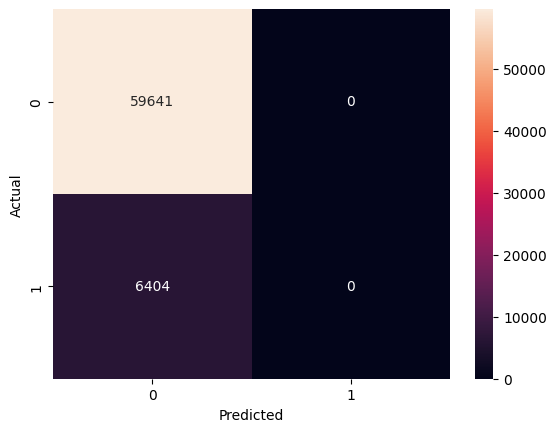

In [9]:
# plot a confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(confusion_matrix(val[target], clf.predict(val[features])), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# #2

In [10]:
# get probability of prediction
clf.predict_proba(val[features])[:, 1]

array([0.17059757, 0.05211023, 0.10395783, ..., 0.13819583, 0.14733361,
       0.10629987])

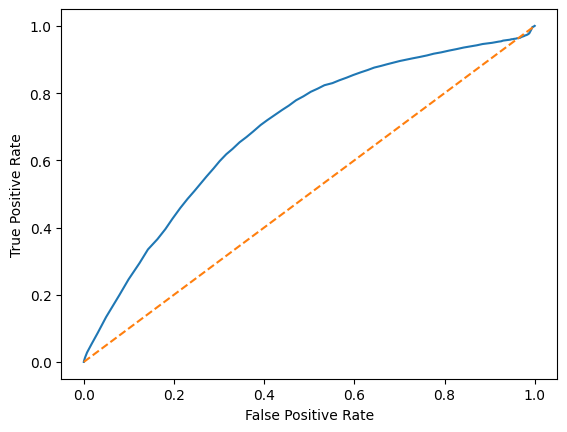

In [11]:
#  Receiver Operating Characteristic (ROC) curves and the AUC metric of the ROC curve. Include a random classifier baseline, i.e. each shot has a 50% chance of being a goal.
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(val[target], clf.predict_proba(val[features])[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


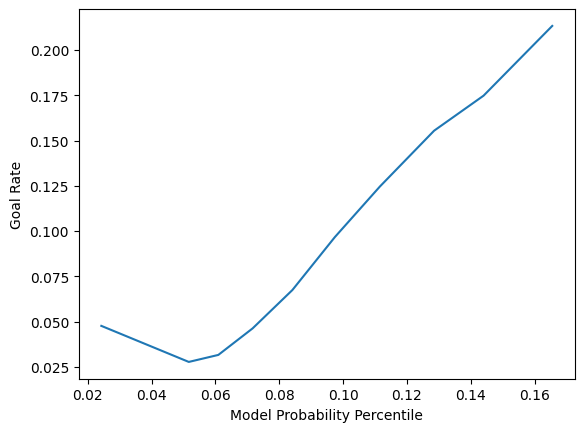

In [20]:
# The goal rate (#goals / (#no_goals + #goals)) as a function of the shot probability model percentile, i.e. if a value is the 70th percentile, it is above 70% of the data.
val['prob'] = clf.predict_proba(val[features])[:, 1]

# get the goal rate
goal_rate = val.groupby(pd.qcut(val['prob'], 10))['is goal'].mean()

# convert interval index to its midpoint values
goal_rate.index = goal_rate.index.map(lambda x: x.mid)

# plot the goal rate
plt.plot(goal_rate)
plt.xlabel('Model Probability Percentile')
plt.ylabel('Goal Rate')
plt.show()





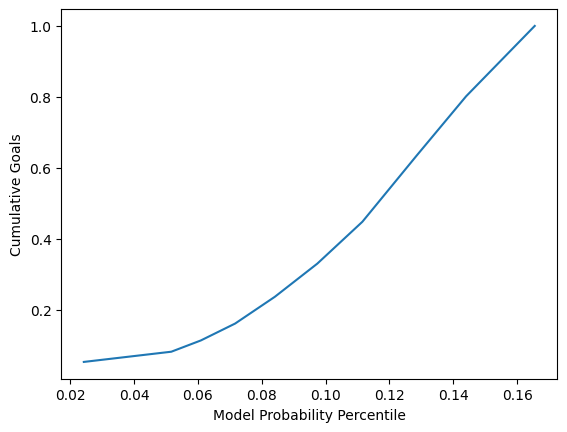

In [22]:
# The cumulative proportion of goals (not shots) as a function of the shot probability model percentile.

# get the cumulative sum of goals
cumulative_goals = val.groupby(pd.qcut(val['prob'], 10))['is goal'].sum().cumsum()

# convert to proportion
cumulative_goals = cumulative_goals / cumulative_goals.max()

# convert interval index to its midpoint values
cumulative_goals.index = cumulative_goals.index.map(lambda x: x.mid)

# plot the cumulative goals
plt.plot(cumulative_goals)
plt.xlabel('Model Probability Percentile')
plt.ylabel('Cumulative Goals')
plt.show()



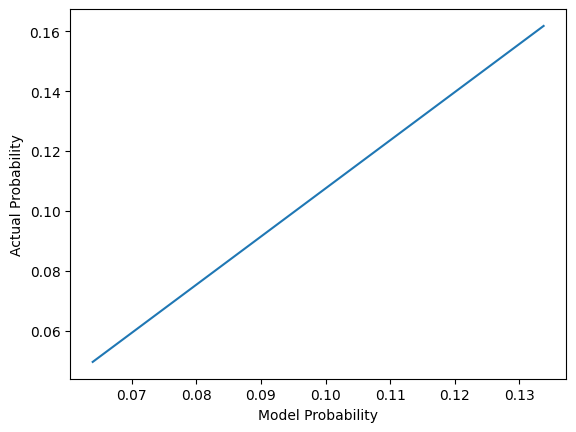

In [23]:
# The reliability diagram (calibration curve). Scikit-learn provides functionality to create a reliability diagram in a few lines of code; check out the CalibrationDisplay API (specifically the .from_estimator() or .from_predictions() methods) for more information.
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(val[target], clf.predict_proba(val[features])[:, 1], n_bins=10)
plt.plot(prob_pred, prob_true)
plt.xlabel('Model Probability')
plt.ylabel('Actual Probability')
plt.show()


In [26]:
# create a function that plots these last 4 plots

def plot_calibration_curve(model, features, target, val, train):
    # initialize the model
    model = model()

    # fit the model
    model.fit(train[features], train[target])

    # get the probability of the prediction
    val['prob'] = model.predict_proba(val[features])[:, 1]
    
    # get the goal rate
    goal_rate = val.groupby(pd.qcut(val['prob'], 10))['is goal'].mean()
    
    # convert interval index to its midpoint values
    goal_rate.index = goal_rate.index.map(lambda x: x.mid)
    
    # get the cumulative sum of goals
    cumulative_goals = val.groupby(pd.qcut(val['prob'], 10))['is goal'].sum().cumsum()
    
    # convert to proportion
    cumulative_goals = cumulative_goals / cumulative_goals.max()
    
    # convert interval index to its midpoint values
    cumulative_goals.index = cumulative_goals.index.map(lambda x: x.mid)
    
    # get the reliability diagram
    prob_true, prob_pred = calibration_curve(val[target], model.predict_proba(val[features])[:, 1], n_bins=10)
    
    # plot the goal rate
    plt.subplot(2, 2, 1)
    plt.plot(goal_rate)
    plt.xlabel('Model Probability Percentile')
    plt.ylabel('Goal Rate')
    
    # plot the cumulative goals
    plt.subplot(2, 2, 2)
    plt.plot(cumulative_goals)
    plt.xlabel('Model Probability Percentile')
    plt.ylabel('Cumulative Goals')
    
    # plot the ROC curve
    plt.subplot(2, 2, 3)
    fpr, tpr, thresholds = roc_curve(val[target], model.predict_proba(val[features])[:, 1])
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # plot the reliability diagram
    plt.subplot(2, 2, 4)
    plt.plot(prob_pred, prob_true)
    plt.xlabel('Model Probability')
    plt.ylabel('Actual Probability')
    
    plt.tight_layout()
    plt.show()

    

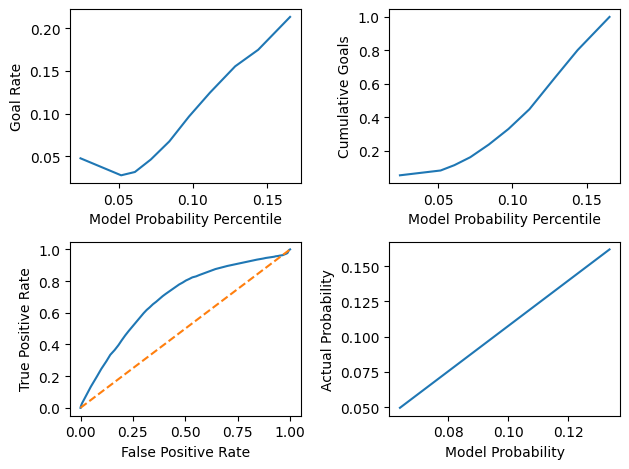

In [28]:
# apply the function
plot_calibration_curve(LogisticRegression, features, target, val, train)

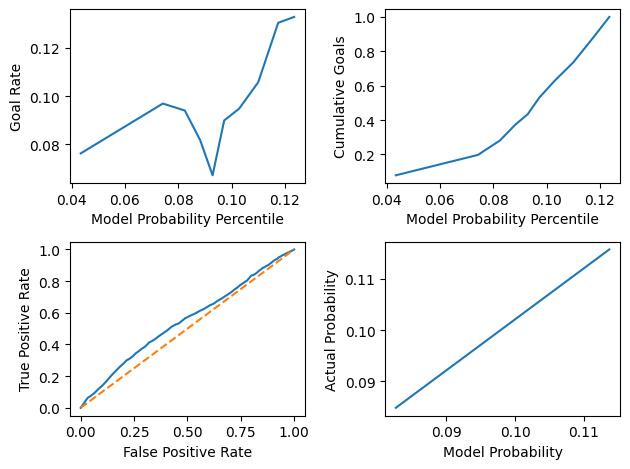

In [29]:
# 3) trained on angle only
features = ['shot angle']
plot_calibration_curve(LogisticRegression, features, target, val, train)

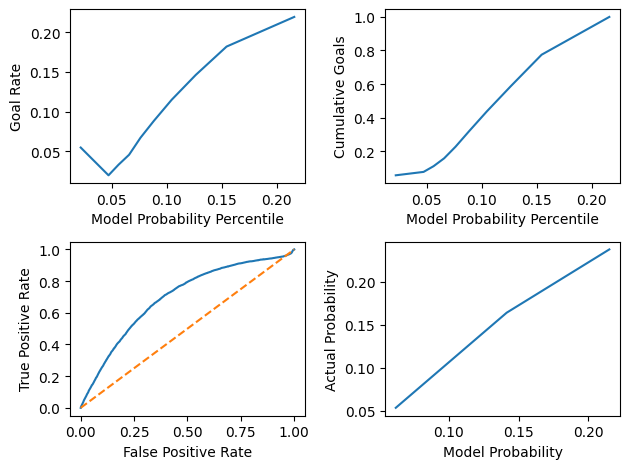

In [30]:
# 3) trained on angle only
features = ['shot angle', 'shot distance']
plot_calibration_curve(LogisticRegression, features, target, val, train)

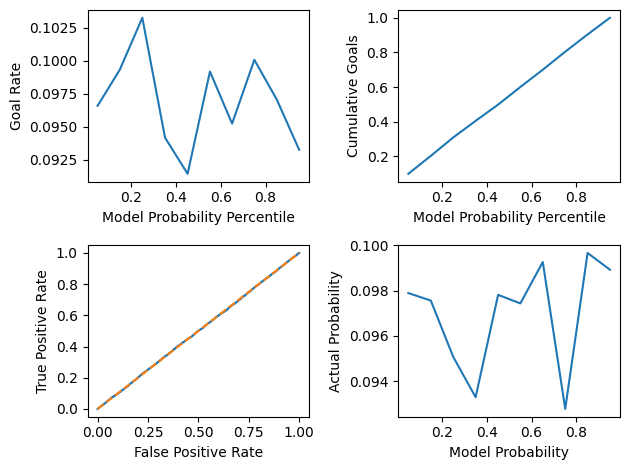

In [43]:
# plot with a model that assign a random probability

class RandomModel:
    def __init__(self):
        pass
    
    def predict_proba(self, X):
        col_1 = np.random.uniform(size= len(X))
        col_2 = 1 - col_1
        return np.column_stack((col_1, col_2))
    
    def fit(self, X, y):
        pass

plot_calibration_curve(RandomModel, features, target, val, train)
